<h1><center>CSCI - 4146 - The Process of Data Science - Summer 2022</h1></center>
<h1><center>Assignment 2</h1></center>

<b>Sarthak Pandit</b>  
<b>B00900388</b>  


<b>Sagar Devesh</b>  
<b>B00905507</b>

In [5]:
# importing the relevant modules
import pandas as pd 
import numpy as np
import warnings
from datetime import date 
import datetime

In [33]:
# Data source
churn_df = pd.read_csv('Telco-Customer-Churn - WA_Fn-UseC_-Telco-Customer-Churn.csv')


## 1. Data Understanding and feature engineering

#### Working towards creating the 'tenure' column as it is required later in the assignment.

We have taken 8th July, 2022 as the base date to calulate the tenure of the customer in the company.

In [7]:
# taking the date on which this cell was executed
today = datetime.date.today() 

In [34]:
churn_df['Today'] = today
churn_df['Today'] = pd.to_datetime(churn_df['Today'])
churn_df['Date'] = pd.to_datetime(churn_df['Date'])
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date,Today
0,0002-ORFBO,Female,0,Yes,Yes,Yes,DSL,No,No,No,...,No,No,One year,Yes,Electronic Check,65.6,593.30,No,2010-01-01,2022-07-11
1,0003-MKNFE,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.9,542.40,No,2010-01-01,2022-07-11
2,0004-TLHLJ,Male,0,No,No,Yes,DSL,No,No,No,...,No,No,Month-to-month,Yes,Credit card (automatic),73.9,280.85,Yes,2010-01-01,2022-07-11
3,0011-IGKFF,Male,1,Yes,No,Yes,DSL,No,No,No,...,No,No,Month-to-month,Yes,Credit card (automatic),98.0,1237.85,Yes,2010-01-02,2022-07-11
4,0013-EXCHZ,Female,1,Yes,No,Yes,DSL,Yes,Yes,No,...,No,No,Month-to-month,Yes,Electronic Check,83.9,267.40,Yes,2010-01-03,2022-07-11


In the cell below, we have calculated the tenure of all the customers by subtracting the joining date ('Date') from today's date ('Today'). [6](https://stackoverflow.com/questions/42822768/pandas-number-of-months-between-two-dates#:~:text=df%5B'month'%5D%20%3D,%2C%20'M')

In [35]:
churn_df['tenure(months)'] = ((churn_df['Today'] - churn_df['Date'])/np.timedelta64(1, 'M')) # Representing the result in months
churn_df['tenure(months)'] = churn_df['tenure(months)'].astype(int)


In [36]:
# Dropping the 'Today' feature as it is no longer required
churn_df = churn_df.drop(['Today'], axis=1) 


### _Question 1.a: Data quality reports for continuous and categorical features_

### Continuous features report

Continous features report includes the following -
1. Minimum
2. 1st quartile
3. Mean
4. 2nd quartile - Median
5. 3rd quartile
6. Maximum
7. Standard deviation
8. Total num of instances
9. % missing values
10. Cardinality - Number of unqiue values for a given feature

In [8]:
#Defining function to generate data quality report for continuous features in the dataset
def build_continuous_features_report(data_df):
    
    stats = {
        "Count": len,
        "Miss %": lambda churn_df: churn_df.isna().sum() / len(churn_df) * 100,
        "Card.": lambda churn_df: churn_df.nunique(),
        "Min": lambda churn_df: churn_df.min(),
        "1st Qrt.": lambda churn_df: churn_df.quantile(0.25),
        "Mean": lambda churn_df: churn_df.mean(),
        "Median": lambda churn_df: churn_df.median(),
        "3rd Qrt": lambda churn_df: churn_df.quantile(0.75),
        "Max": lambda churn_df: churn_df.max(),
        "Std. Dev.": lambda churn_df: churn_df.std(),
    }
    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [9]:
build_continuous_features_report(churn_df)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
SeniorCitizen,7043,0.000000,2,0.00,0.00,0.162147,0.000,0.0000,1.00,0.368612
MonthlyCharges,7043,0.000000,1585,18.25,35.50,64.761692,70.350,89.8500,118.75,30.090047
TotalCharges,7043,0.156183,6530,18.80,401.45,2283.300441,1397.475,3794.7375,8684.80,2266.771362
tenure(months),7043,0.000000,133,18.00,51.00,83.213971,83.000,116.0000,150.00,37.984560


#### Missing Values
We see that the 'TotalCharges' feature has 0.15% missing values. 

### Continuous features report

Categorical features report includes:
1. Mode - most repeated value (value with highest frequency)
2. 2nd mode - 2nd most repeated value
3. Frequency of mode
4. Proportion of mode in the dataset
5. Frequency of 2nd mode
6. Proportion of 2nd mode in the dataset
7. % missing values
8. Cardinality - number of unique values for a given feature


In [10]:
#Defining function to generate data quality report for categorical features in the dataset
def build_categorical_features_report(data_df):

    def _mode(churn_df):
        return churn_df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(churn_df):
        return churn_df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(churn_df):
        return churn_df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(churn_df):
        return churn_df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda churn_df: churn_df.isna().sum() / len(churn_df) * 100,
        "Card.": lambda churn_df: churn_df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda churn_df: _mode_freq(churn_df) / len(churn_df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda churn_df: _second_mode_freq(churn_df) / len(churn_df) * 100,
    }

    feature_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[feature_names]
    report_df = pd.DataFrame(index=feature_names, columns=stats.keys())
    
    
    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df



In [11]:
build_categorical_features_report(churn_df)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
customerID,7043,0.0,7043,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF...",7043,100.000000,[],0,0.000000
gender,7043,0.0,2,[Male],3555,50.475650,[Female],3488,49.524350
Partner,7043,0.0,2,[No],3641,51.696720,[Yes],3402,48.303280
Dependents,7043,0.0,2,[No],4933,70.041176,[Yes],2110,29.958824
PhoneService,7043,0.0,2,[Yes],5016,71.219651,[No],2027,28.780349
InternetService,7043,0.0,3,[Fiber optic],2917,41.417010,[DSL],2708,38.449524
OnlineSecurity,7043,0.0,3,[No],3584,50.887406,[Yes],2041,28.979128
OnlineBackup,7043,0.0,3,[No],3543,50.305268,[Yes],2082,29.561267
DeviceProtection,7043,0.0,3,[No],3518,49.950305,[Yes],2107,29.916229
TechSupport,7043,0.0,3,[No],3547,50.362062,[Yes],2078,29.504473


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Feature Visualization for continuous features


#### Monthly Charges

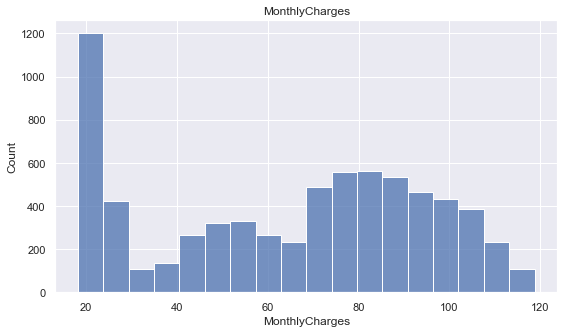

In [15]:
plt.figure(figsize=(9,5))
sns.histplot(data=churn_df,x="MonthlyCharges")
plt.title('MonthlyCharges')
plt.show()

#### Total Charges

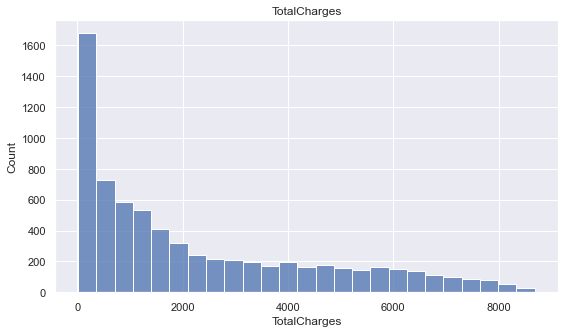

In [16]:
plt.figure(figsize=(9,5))
sns.histplot(data=churn_df,x="TotalCharges")
plt.title('TotalCharges')
plt.show()

#### Senior Citizen

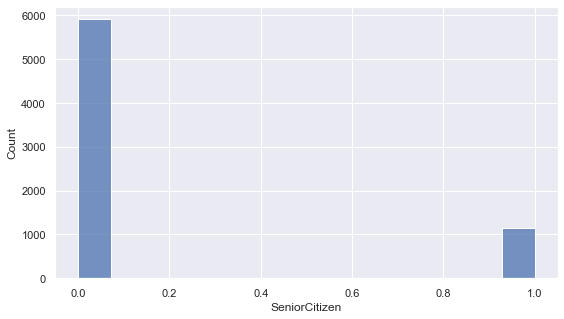

In [21]:
# churn_df.hist(column=['SeniorCitizen'])
# plt.show()
plt.figure(figsize=(9,5))
sns.histplot(data=churn_df,x="SeniorCitizen")
plt.show()

The above chart shows that majority of the customers are not senior citizens. 

#### Tenure

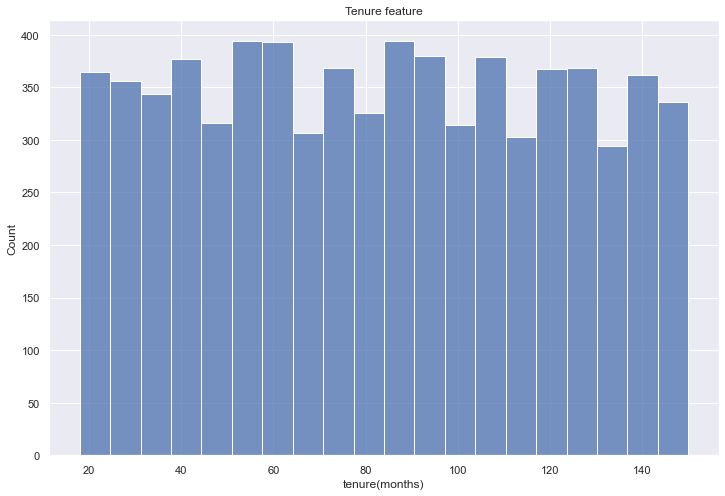

In [20]:
plt.figure(figsize=(12,8))
sns.histplot(data=churn_df,x="tenure(months)")
plt.title('Tenure feature')
plt.show()

### Feature Visualization for categorical features


#### Gender

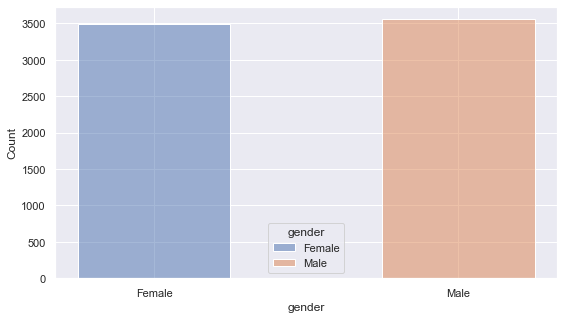

In [232]:
# churn_df['gender'].value_counts().plot.bar();
plt.figure(figsize=(9,5))
sns.histplot(x= "gender", data=churn_df, palette ='deep', shrink=0.5, hue = "gender");

The above figure shows that there are almost equal number of male and female customers.

#### Dependents


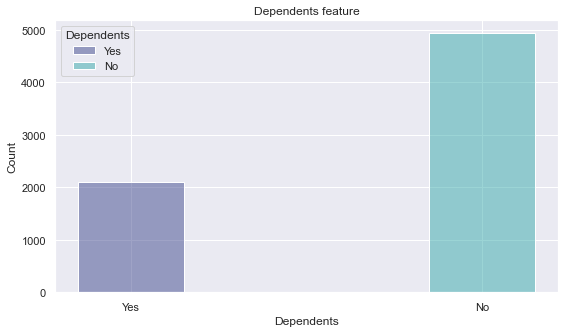

In [245]:
# churn_df['Dependents'].value_counts().plot.bar();
plt.figure(figsize=(9,5))
sns.histplot(data=churn_df,x="Dependents", palette='mako', shrink=0.3, hue='Dependents')
plt.title('Dependents feature')
plt.show()


Majority of the customer have no dependants

#### Partner

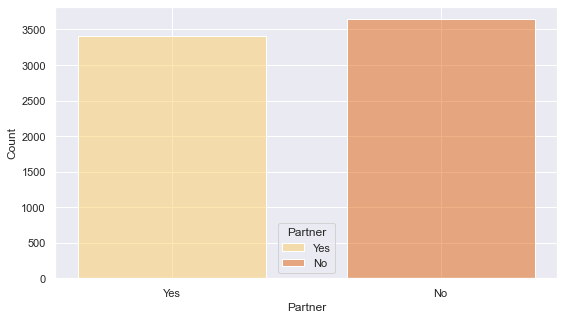

In [243]:
# churn_df['Partner'].value_counts().plot.bar();
plt.figure(figsize=(9,5))
sns.histplot(x= "Partner", data=churn_df,shrink=.7 ,  palette ='YlOrBr',hue = "Partner");

#### Phone Service

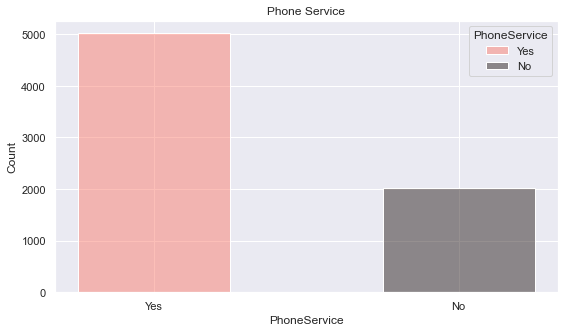

In [26]:
plt.figure(figsize=(9,5))
sns.histplot(x= "PhoneService", data=churn_df,shrink=.5 ,  palette ='dark:salmon_r',hue = "PhoneService");
plt.title('Phone Service')
plt.show()

#### Internet Service

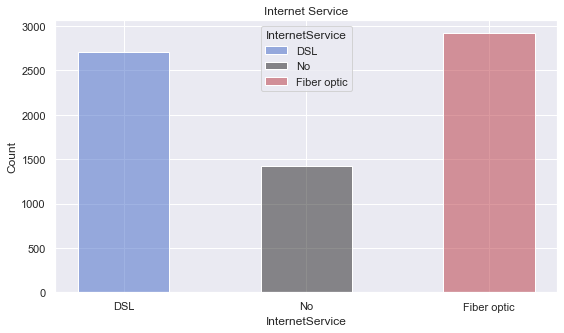

In [28]:
plt.figure(figsize=(9,5))
sns.histplot(x= "InternetService", data=churn_df,shrink=.5 ,  palette ='icefire',hue = "InternetService");
plt.title('Internet Service')
plt.show()

#### Online Security

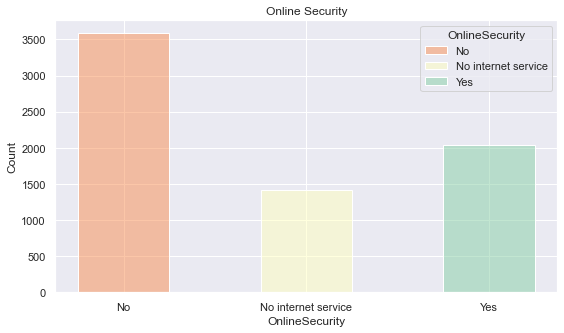

In [31]:
plt.figure(figsize=(9,5))
sns.histplot(x= "OnlineSecurity", data=churn_df,shrink=.5 ,  palette ='Spectral',hue = "OnlineSecurity");
plt.title('Online Security')
plt.show()

#### Online Backup

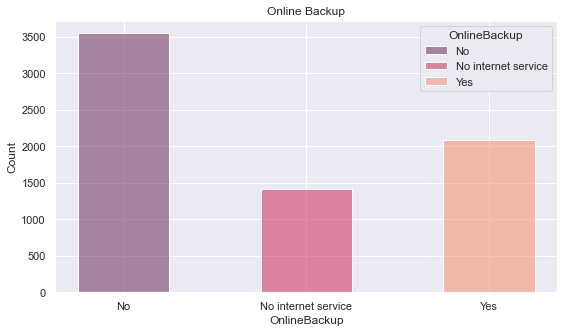

In [38]:
plt.figure(figsize=(9,5))
sns.histplot(x= "OnlineBackup", data=churn_df,shrink=.5, palette ='rocket', hue = "OnlineBackup");
plt.title('Online Backup')
plt.show()

#### Device Protection

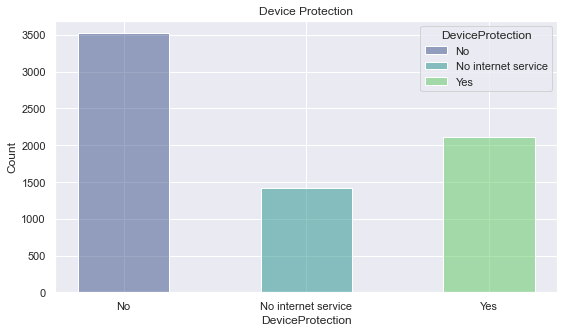

In [39]:
plt.figure(figsize=(9,5))
sns.histplot(x= "DeviceProtection", data=churn_df,shrink=.5, palette ='viridis', hue = "DeviceProtection");
plt.title('Device Protection')
plt.show()

#### Tech Support

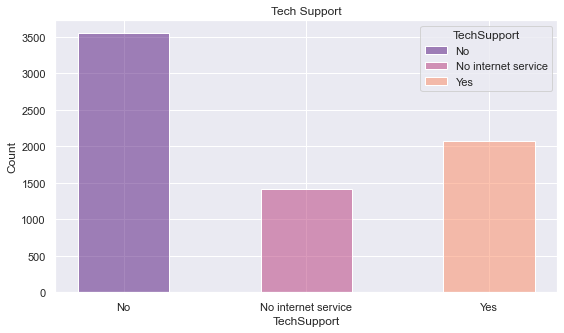

In [40]:
plt.figure(figsize=(9,5))
sns.histplot(x= "TechSupport", data=churn_df,shrink=.5, palette ='magma', hue = "TechSupport");
plt.title('Tech Support')
plt.show()

#### Streaming TV

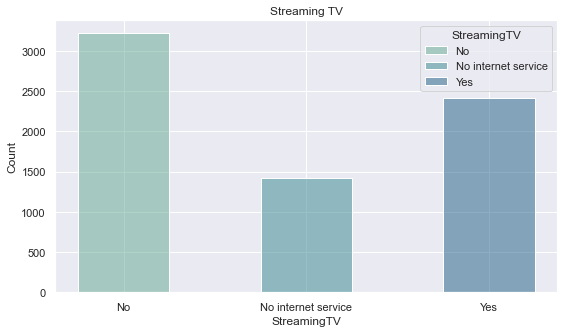

In [41]:
plt.figure(figsize=(9,5))
sns.histplot(x= "StreamingTV", data=churn_df,shrink=.5, palette ='crest', hue = "StreamingTV");
plt.title('Streaming TV')
plt.show()

#### Streaming Movies 

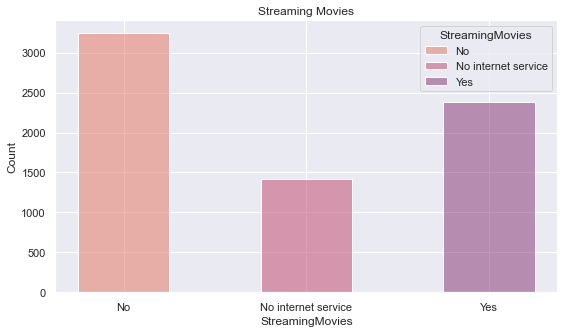

In [42]:
plt.figure(figsize=(9,5))
sns.histplot(x= "StreamingMovies", data=churn_df,shrink=.5, palette ='flare', hue = "StreamingMovies");
plt.title('Streaming Movies')
plt.show()

#### Contract

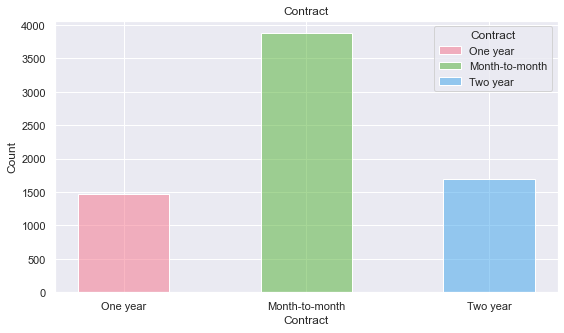

In [44]:
plt.figure(figsize=(9,5))
sns.histplot(x= "Contract", data=churn_df,shrink=.5, palette ='husl', hue = "Contract");
plt.title('Contract')
plt.show()

The above figure depicts that most customers opt for monthly contracts rather than yearly or bi-yearly contracts.

#### Paperless Billing

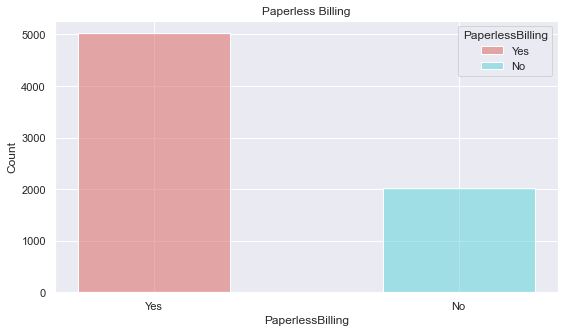

In [45]:
plt.figure(figsize=(9,5))
sns.histplot(x= "PaperlessBilling", data=churn_df,shrink=.5, palette ='hls', hue = "PaperlessBilling");
plt.title('Paperless Billing')
plt.show()

#### Payment Method

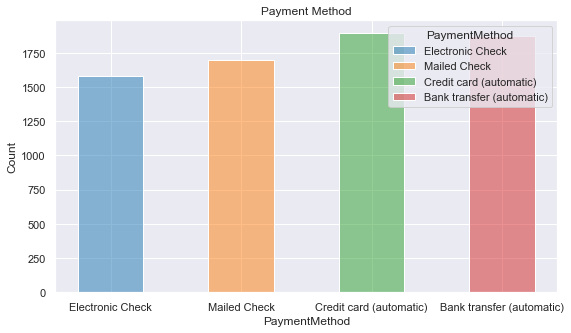

In [46]:
plt.figure(figsize=(9,5))
sns.histplot(x= "PaymentMethod", data=churn_df,shrink=.5, palette ='tab10', hue = "PaymentMethod");
plt.title('Payment Method')
plt.show()

#### Churn

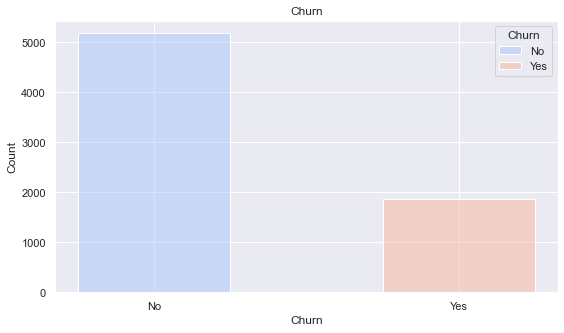

In [48]:
plt.figure(figsize=(9,5))
sns.histplot(x= "Churn", data=churn_df,shrink=.5, palette ='coolwarm', hue = "Churn");
plt.title('Churn')
plt.show()

### _Question 1.b: Data Quality Issues and Data Quality Plan_

#### Missing Values 

In [49]:
churn_df.isnull().sum().sort_values(ascending=False) # to check for null values

TotalCharges        11
customerID           0
StreamingTV          0
Date                 0
Churn                0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
TechSupport          0
gender               0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
PhoneService         0
Dependents           0
Partner              0
SeniorCitizen        0
tenure(months)       0
dtype: int64

In [50]:
churn_df.count()

customerID          7043
gender              7043
SeniorCitizen       7043
Partner             7043
Dependents          7043
PhoneService        7043
InternetService     7043
OnlineSecurity      7043
OnlineBackup        7043
DeviceProtection    7043
TechSupport         7043
StreamingTV         7043
StreamingMovies     7043
Contract            7043
PaperlessBilling    7043
PaymentMethod       7043
MonthlyCharges      7043
TotalCharges        7032
Churn               7043
Date                7043
tenure(months)      7043
dtype: int64

As we can see from the above output, there are 11 missing values for 'TotalCharges' feature. In the preprocessing step, we will drop the rows that have missing values for this feature. 

#### Converting the 'Date' column to datetime format:

In [51]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   PhoneService      7043 non-null   object        
 6   InternetService   7043 non-null   object        
 7   OnlineSecurity    7043 non-null   object        
 8   OnlineBackup      7043 non-null   object        
 9   DeviceProtection  7043 non-null   object        
 10  TechSupport       7043 non-null   object        
 11  StreamingTV       7043 non-null   object        
 12  StreamingMovies   7043 non-null   object        
 13  Contract          7043 non-null   object        
 14  PaperlessBilling  7043 n

The date feature in the dataset contains values in the string format. We will convert the values into the datetime format during data preprocessing.

#### Dropping features

We will drop the features which will not eventually contribute towards making predictions when we build our model. 

#### Chi-Square test 

We will perform Chi-square test to check the correlation between 2 features in the dataframe. Our null hypothesis is that any two given features are not correlated with each other and are independent. 
If the P-value comes higher than 0.05, our null hypothesis will be accepted. Otherwise, we will reject our null hypothesis and conclude that the 2 features are highly correlated. [9](https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43)

In [52]:
from scipy.stats import chi2_contingency

In [53]:
CrosstabResult = pd.crosstab(index=churn_df['OnlineSecurity'],columns=churn_df['OnlineBackup'])
print(CrosstabResult)

OnlineBackup           No  No internet service   Yes
OnlineSecurity                                      
No                   2535                    0  1049
No internet service     0                 1418     0
Yes                  1008                    0  1033


In [54]:
ChiSqResult = chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:',ChiSqResult[1])

The P-Value of the ChiSq Test is: 0.0


The above P-value of 0.0 indicates that features 'OnlineSecurity' and 'OnlineBackup' are highly correlated. Hence, during data preprocessing, we will go ahead and drop one of these 2 features, as having both the features in our model will not improve the accuracy of our model in anyway.

In [55]:
CrosstabResult1 = pd.crosstab(index=churn_df['StreamingMovies'],columns=churn_df['Churn'])
print(CrosstabResult1)

Churn                  No  Yes
StreamingMovies               
No                   2401  840
No internet service  1034  384
Yes                  1739  645


In [56]:
ChiSqResult1 = chi2_contingency(CrosstabResult1)
print('The P-Value of the ChiSq Test is:',ChiSqResult1[1])

The P-Value of the ChiSq Test is: 0.5541815121346254


Similarly, the p-value of 0.55 above suggests that our null hypothesis that features 'StreamingMovies' and 'Churn' are independent, is true. Hence, we won't drop any of the 2 features. 

In [57]:
CrosstabResult2 = pd.crosstab(index=churn_df['StreamingMovies'],columns=churn_df['StreamingTV'])
ChiSqResult2 = chi2_contingency(CrosstabResult2)
print('The P-Value of the ChiSq Test is:',ChiSqResult2[1])

The P-Value of the ChiSq Test is: 0.0


Features 'StreamingMovies' and 'StreamingTV' are highly correlated, so we will drop one of these 2 features during data preprocessing. 

In [58]:
CrosstabResult3 = pd.crosstab(index=churn_df['TechSupport'],columns=churn_df['DeviceProtection'])
ChiSqResult3 = chi2_contingency(CrosstabResult3)
print('The P-Value of the ChiSq Test is:',ChiSqResult3[1])


The P-Value of the ChiSq Test is: 0.0


Features 'TechSupport' and 'DeviceProtection' are highly correlated, so we will drop one of these 2 features during data preprocessing.

In [59]:
CrosstabResult4 = pd.crosstab(index=churn_df['Churn'],columns=churn_df['PaperlessBilling'])
ChiSqResult4 = chi2_contingency(CrosstabResult4)
print('The P-Value of the ChiSq Test is:',ChiSqResult4[1])


The P-Value of the ChiSq Test is: 0.48875793317161653


In [60]:
churn_df['StreamingTV'].value_counts()

No                     3216
Yes                    2409
No internet service    1418
Name: StreamingTV, dtype: int64

In [61]:
churn_df['StreamingMovies'].value_counts()

No                     3241
Yes                    2384
No internet service    1418
Name: StreamingMovies, dtype: int64

To further validate our analysis on correlation between features, we can see below that 'OnlineBackup', 'OnlineSecurity' and 'TechSupport' have very similar numbers. We can just choose one of these 3 features for our model. 

In [62]:
churn_df['OnlineBackup'].value_counts()

No                     3543
Yes                    2082
No internet service    1418
Name: OnlineBackup, dtype: int64

In [63]:
churn_df['OnlineSecurity'].value_counts()

No                     3584
Yes                    2041
No internet service    1418
Name: OnlineSecurity, dtype: int64

In [64]:
churn_df['TechSupport'].value_counts()

No                     3547
Yes                    2078
No internet service    1418
Name: TechSupport, dtype: int64

In [65]:
churn_df['DeviceProtection'].value_counts()

No                     3518
Yes                    2107
No internet service    1418
Name: DeviceProtection, dtype: int64

Also, the feature 'customerID' consists of just unique identifiers, and will play no role in enhancing the accuracy of model's prediction. Hence, we will go ahead and drop this feature during data preprocessing.


#### Reset index

The dataset that we will obtain after removing rows with null values may have unordered index. We will reset the index of the resulting dataframe during preprocessing.

#### One-hot encoding

In the end, we will perform one-hot encoding for all the categorical features which will convert the values of those features into binary values of 0 and 1. 


### _Question 1.c: Prepocessing_

#### Dropping rows containing null values

In [12]:
churn_df = churn_df.dropna()

In [67]:
churn_df.isnull().sum().sort_values(ascending=False) # to check for null values

customerID          0
StreamingTV         0
Date                0
Churn               0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
TechSupport         0
gender              0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
PhoneService        0
Dependents          0
Partner             0
SeniorCitizen       0
tenure(months)      0
dtype: int64

#### Converting all the features of the dataframe to the best possible data types.

In [68]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   PhoneService      7032 non-null   object        
 6   InternetService   7032 non-null   object        
 7   OnlineSecurity    7032 non-null   object        
 8   OnlineBackup      7032 non-null   object        
 9   DeviceProtection  7032 non-null   object        
 10  TechSupport       7032 non-null   object        
 11  StreamingTV       7032 non-null   object        
 12  StreamingMovies   7032 non-null   object        
 13  Contract          7032 non-null   object        
 14  PaperlessBilling  7032 n

In [13]:
churn_df = churn_df.convert_dtypes()
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   string        
 1   gender            7032 non-null   string        
 2   SeniorCitizen     7032 non-null   Int64         
 3   Partner           7032 non-null   string        
 4   Dependents        7032 non-null   string        
 5   PhoneService      7032 non-null   string        
 6   InternetService   7032 non-null   string        
 7   OnlineSecurity    7032 non-null   string        
 8   OnlineBackup      7032 non-null   string        
 9   DeviceProtection  7032 non-null   string        
 10  TechSupport       7032 non-null   string        
 11  StreamingTV       7032 non-null   string        
 12  StreamingMovies   7032 non-null   string        
 13  Contract          7032 non-null   string        
 14  PaperlessBilling  7032 n

#### Converting the dates into datetime format

We have already converted the date column to datetime type while creating the tenure feature at the beginning og the notebook.

#### Dropping features 

As discussed in the data quality plan, we will drop features that are highly correlational.

In [14]:
churn_df = churn_df.drop(['OnlineSecurity', 'TechSupport', 'StreamingTV', 'customerID'], axis=1) 
churn_df.head()


,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineBackup,DeviceProtection,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date,tenure(months)
0,Female,0,Yes,Yes,Yes,DSL,No,No,No,One year,Yes,Electronic Check,65.6,593.3,No,2010-01-01,150
1,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.9,542.4,No,2010-01-01,150
2,Male,0,No,No,Yes,DSL,No,No,No,Month-to-month,Yes,Credit card (automatic),73.9,280.85,Yes,2010-01-01,150
3,Male,1,Yes,No,Yes,DSL,No,No,No,Month-to-month,Yes,Credit card (automatic),98.0,1237.85,Yes,2010-01-02,150
4,Female,1,Yes,No,Yes,DSL,Yes,No,No,Month-to-month,Yes,Electronic Check,83.9,267.4,Yes,2010-01-03,150


#### Reset index

In [15]:
# resetting the index of the dataframe
churn_df.reset_index(drop=True, inplace=True)
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineBackup,DeviceProtection,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date,tenure(months)
0,Female,0,Yes,Yes,Yes,DSL,No,No,No,One year,Yes,Electronic Check,65.6,593.3,No,2010-01-01,150
1,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.9,542.4,No,2010-01-01,150
2,Male,0,No,No,Yes,DSL,No,No,No,Month-to-month,Yes,Credit card (automatic),73.9,280.85,Yes,2010-01-01,150
3,Male,1,Yes,No,Yes,DSL,No,No,No,Month-to-month,Yes,Credit card (automatic),98.0,1237.85,Yes,2010-01-02,150
4,Female,1,Yes,No,Yes,DSL,Yes,No,No,Month-to-month,Yes,Electronic Check,83.9,267.4,Yes,2010-01-03,150


#### One hot encoding

Using one hot encoding to convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. One hot encoding will help the model to make better predictions. 


In [16]:
churn_df_one_hot = pd.get_dummies(churn_df, columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'OnlineBackup', 'DeviceProtection', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'])

In [17]:
churn_df_one_hot['Churn'] = churn_df_one_hot['Churn'].map({'Yes':1, 'No':0})

In [111]:
churn_df_one_hot.head()

,customerID,OnlineSecurity,TechSupport,StreamingTV,MonthlyCharges,TotalCharges,Churn,Date,tenure(months),gender_Female,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check
0,0002-ORFBO,No,No,No,65.6,593.30,0,2010-01-01,150,1,...,0,0,1,0,0,1,0,0,1,0
1,0003-MKNFE,No internet service,No internet service,No internet service,59.9,542.40,0,2010-01-01,150,0,...,0,1,0,0,0,1,0,0,0,1
2,0004-TLHLJ,No,No,No,73.9,280.85,1,2010-01-01,150,0,...,0,1,0,0,0,1,0,1,0,0
3,0011-IGKFF,No,No,No,98.0,1237.85,1,2010-01-02,150,0,...,0,1,0,0,0,1,0,1,0,0
4,0013-EXCHZ,Yes,No,No,83.9,267.40,1,2010-01-03,150,1,...,0,1,0,0,0,1,0,0,1,0


Churn is going to be our target feature, hence reordering the columns such that the target feature appears at the end of the column 

In [18]:
churn_df_one_hot.columns.values

array(['MonthlyCharges', 'TotalCharges', 'Churn', 'Date',
       'tenure(months)', 'gender_Female', 'gender_Male',
       'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No',
       'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic Check', 'PaymentMethod_Mailed Check'],
      dtype=object)

In [19]:
columns_reordered = ['gender_Female',
       'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'PhoneService_No', 'PhoneService_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No',
       'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic Check', 'PaymentMethod_Mailed Check', 'MonthlyCharges', 'TotalCharges', 'Date', 'tenure(months)', 'Churn']

In [20]:
churn_df_one_hot = churn_df_one_hot[columns_reordered]
churn_df_one_hot.head()

,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,MonthlyCharges,TotalCharges,Date,tenure(months),Churn
0,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,0,65.6,593.3,2010-01-01,150,0
1,0,1,1,0,1,0,1,0,0,1,...,1,0,0,0,1,59.9,542.4,2010-01-01,150,0
2,0,1,1,0,1,0,1,0,0,1,...,1,0,1,0,0,73.9,280.85,2010-01-01,150,1
3,0,1,0,1,0,1,1,0,0,1,...,1,0,1,0,0,98.0,1237.85,2010-01-02,150,1
4,1,0,0,1,0,1,1,0,0,1,...,1,0,0,1,0,83.9,267.4,2010-01-03,150,1


### _Question 1.d: Finding patterns in the data_

Establishing the relationship between tenure and churn.

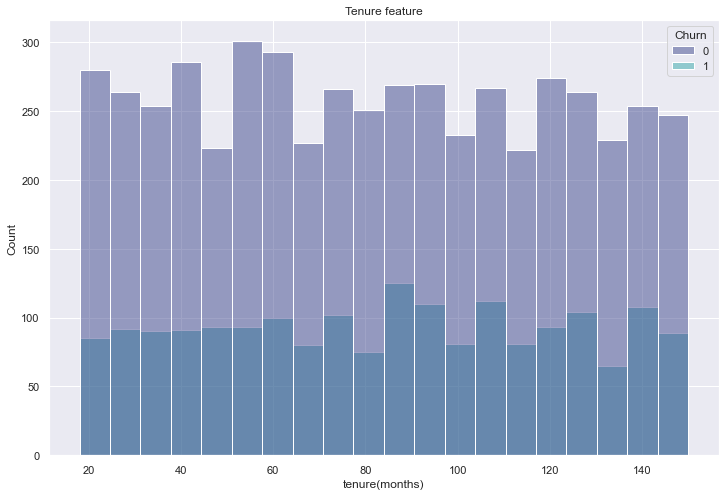

In [116]:
plt.figure(figsize=(12,8))
sns.histplot(data=churn_df_one_hot,x="tenure(months)",hue='Churn', palette='mako')
plt.title('Tenure feature')
plt.show()

The above figure shows that tenure does not really affect the decision of the customer to churn.

#### Relationship between tenure and different contract variables. 

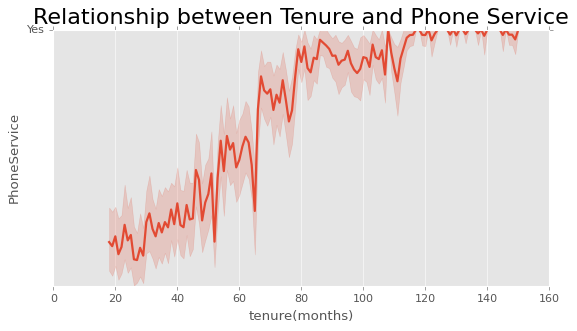

In [180]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'PhoneService')
plt.title('Relationship between Tenure and Phone Service', fontsize=20 )
plt.style.use('fivethirtyeight')
plt.show()

The above figure shows that as the tenure of the customer increases, the use of phone services also increases.

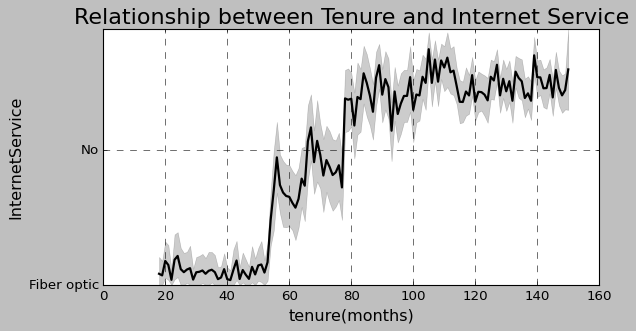

In [179]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'InternetService')
plt.title('Relationship between Tenure and Internet Service', fontsize=20)
plt.style.use('ggplot')
plt.show()

The above line graph portrays that as the tenure of the customer increases, they switch from fibre optic to DSL internet service. More tenured customers prefer DSL over fibre optic.

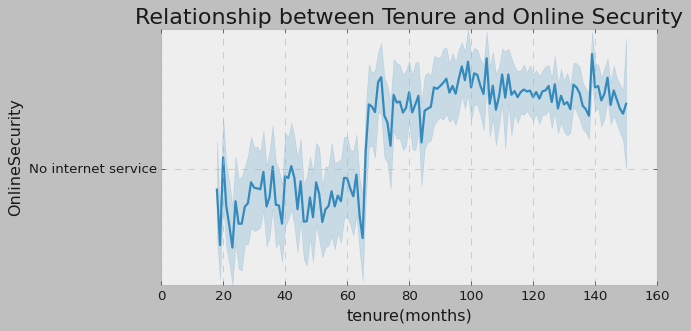

In [178]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'OnlineSecurity')
plt.title('Relationship between Tenure and Online Security', fontsize=20)
plt.style.use('grayscale')
plt.show()

As the tenures of the customers increase, they opt for online security as a service

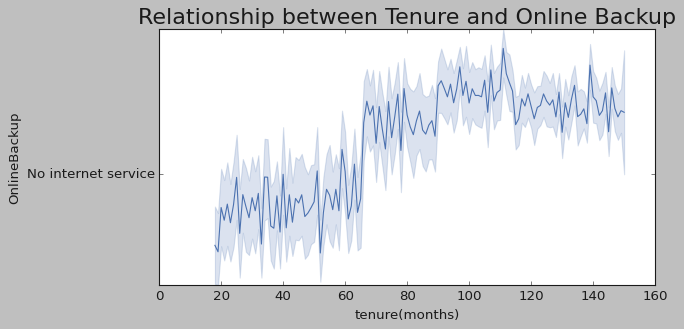

In [177]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'OnlineBackup')
plt.title('Relationship between Tenure and Online Backup', fontsize=20)
plt.style.use('bmh')
plt.show()

Online Backup has a pretty similar trend with respect to tenure, when compared with online security.

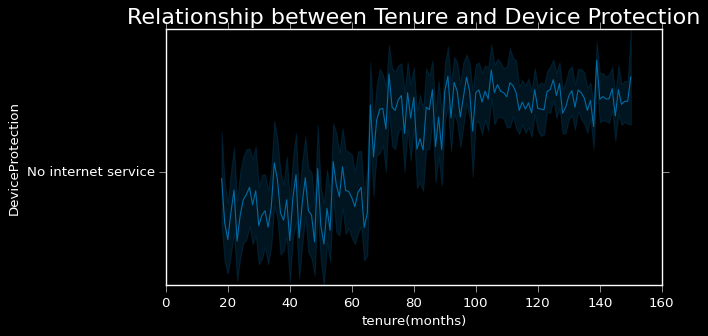

In [176]:
plt.figure(figsize=(8, 4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'DeviceProtection')
plt.title('Relationship between Tenure and Device Protection', fontsize=20)
plt.style.use('classic')
plt.show()

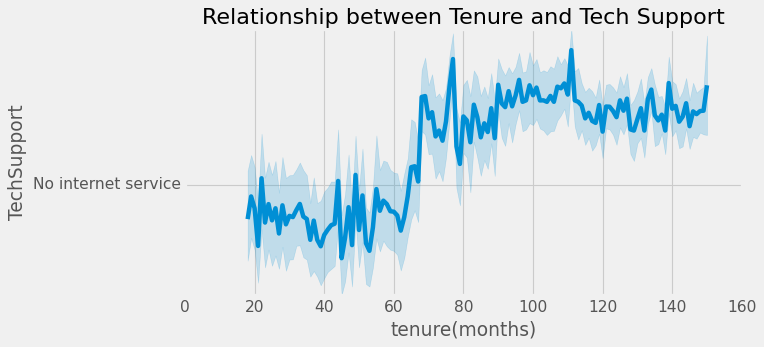

In [181]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'TechSupport')
plt.title('Relationship between Tenure and Tech Support', fontsize=20)
plt.style.use('tableau-colorblind10')
plt.show()

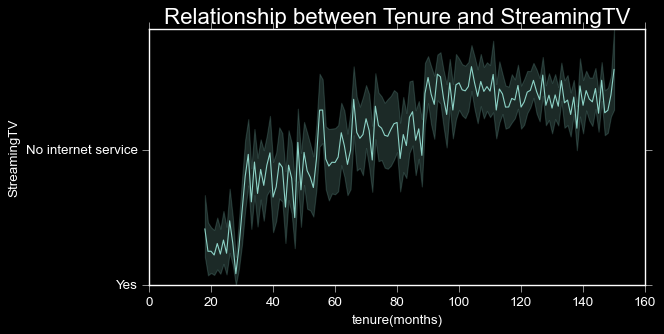

In [174]:
plt.figure(figsize=(8,4))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'StreamingTV')
plt.title('Relationship between Tenure and StreamingTV', fontsize=20)
plt.style.use('dark_background')
plt.show()

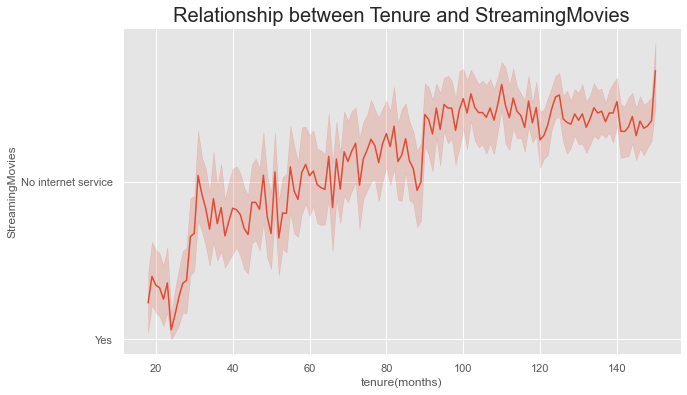

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot(data = churn_df, x = 'tenure(months)', y = 'StreamingMovies')
plt.title('Relationship between Tenure and StreamingMovies', fontsize=20)
plt.style.use('ggplot')
plt.show()

For almost all the contract variables, we can see that as the tenure increases, the services also increase. The slope of increase, however slightly varies from service to service. Since customers avail more and more services with increase in tenure, we see that the graph for tech support also is on the rise, suggesting that using more services may require more online support or tech support. 

#### Visualisation for different services

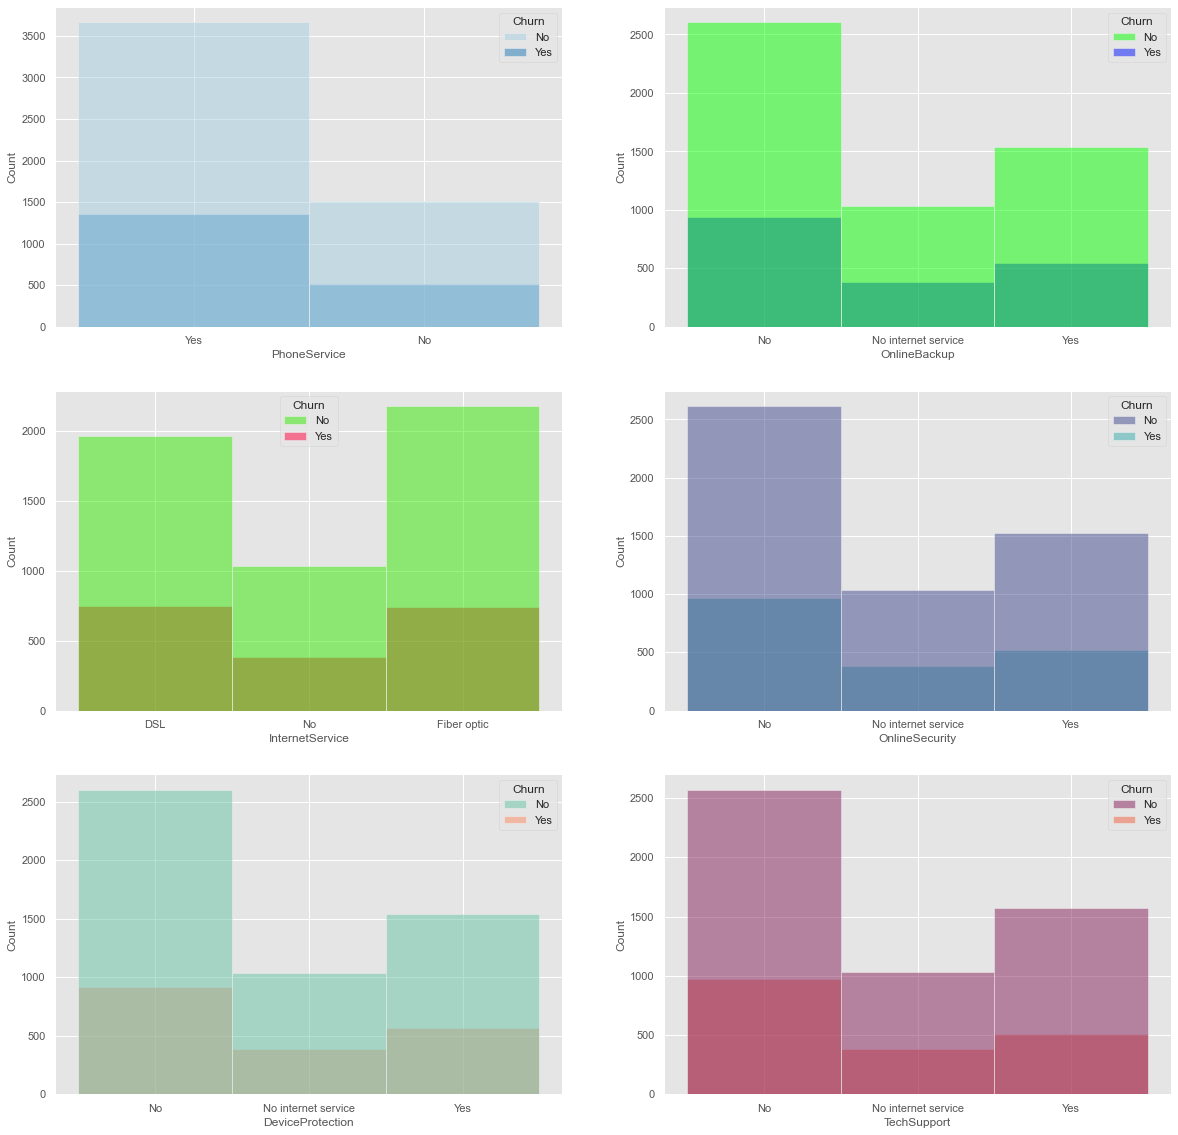

In [57]:
fig, ax = plt.subplots(3, 2,figsize=(20,20))
sns.histplot(data=churn_df,x="PhoneService",hue='Churn', palette='Paired',ax=ax[0,0])
sns.histplot(data=churn_df,x="InternetService",hue='Churn', palette='prism',ax=ax[1,0])
sns.histplot(data=churn_df,x="OnlineBackup",hue='Churn', palette='hsv',ax=ax[0,1])
sns.histplot(data=churn_df,x="OnlineSecurity",hue='Churn', palette='mako',ax=ax[1,1])
sns.histplot(data=churn_df,x="DeviceProtection",hue='Churn', palette='Set2',ax=ax[2,0])
sns.histplot(data=churn_df,x="TechSupport",hue='Churn', palette='rocket',ax=ax[2,1])
plt.show()

The above plots show the distribution of each service and how each service affects churn. [6](https://www.kaggle.com/code/mhslearner/telecom-churn-prediction/notebook) That dataframe used is the one before any of the features were dropped.

For example, customers using the phone services are more likely to churn, as compared to customers not using the phone services.

Similarly, customers who are not availing the online backup services are more likely to churn. We can arrive at superficial conclusions similarly for all the other services by looking at the above figures. 

###  _Question 2_ 
Implementing superivsed learning using random forest classifier

### Importing data
Once the data is pre-processed, we can import the pre-processed file to build a baseline model. The baseline model will predict 'Churn' value. 
Since we know our target variable, it is a supervised learning. We will be implementing supervised learning algorithm.
After studying the data, we analyse the values present in the column 'Churn'. It is a boolean variable that only contains 'Yes' or 'No', which qualifies as a classifer. Hence, we will be going with superivsed classificating predicitive algorithm.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('/Users/sarthakpandit/eclipse-workspace/Data-Science/Assignment2/Preprocessed_with_tenure.csv')

### Feature Selection Method
Generating data correlation report, by calculating correlation coefficient based 'Churn' column and selecting top 3 features that cross the threshold of 0.15.

In [4]:
df = data
corr = df.corr()
#Correlation with the output variable - 'Churn'
cor_target = abs(corr["Churn"])
#Selecting highly correlated features
#Selecting all the features that have a correlation coefficient more than 0.2 to get a list of top features
relevant_features = cor_target[cor_target>0.15]
relevant_features = relevant_features.drop('Churn')
relevant_features.sort_values(ascending = False)

Contract_Month-to-month    0.404565
Contract_Two year          0.301552
TotalCharges               0.199484
MonthlyCharges             0.192858
Contract_One year          0.178225
Dependents_Yes             0.163128
Dependents_No              0.163128
SeniorCitizen_1            0.150541
SeniorCitizen_0            0.150541
Name: Churn, dtype: float64

Taking the top 3 features to build our model - Contract_Month-to-month, Contract_Two year, TotalCharges

As a baseline model, we will take Random Forest classifier as the target variable is categorical feature.

In [5]:
import numpy as np

#Storing the target variable 
labels = np.array(df['Churn'])

#Seggregating our dataset from target variable by removing it from the dataset.
df_updated = df.drop('Churn', axis = 1)

df_update_list = list(df_updated.columns)

df_updated = np.array(df_updated)

Once we have our dataset ready, we will split it into validation ,training and testing in the ratio of 40:30:30.
We will first seggregate training data in ratio with the rest of the data in 40:60 ratio. 

In [6]:
#Splitting data into validation, testing and training in a ratio of 40:30:30
X_train, X_rem, Y_train, Y_rem = train_test_split(df_updated, labels,train_size = 0.4)

From the remainder of the data, we will seggregate split our data into half in between validation and testing data.

In [7]:
#Splitting the remainder data into equal split size
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size = 0.5)

Since the data in our target variable is categorical, we will be using classification model to predict our target variable. For this purpose, our baseline model will be Random Forest Classifier. 


Using Contract_Month-to-month, Contract_Two year, TotalCharges as our top features to predicts the values of our target varaible. 

In [20]:
#Importing the model we are using 
from sklearn.ensemble import RandomForestClassifier

# Random forest with only the top three important variables
rf_most_important = RandomForestClassifier()
#Pinning the important indices
important_indices = [df_update_list.index('Contract_Month-to-month'), df_update_list.index('TotalCharges'), df_update_list.index('Contract_Two year')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]
valid_important = X_valid[:, important_indices]


#Fitting the model to the data
rf_train = rf_most_important.fit(train_important[:], Y_train)

#Once the model has been trained to learn the relationship between input and target variables
#We can use it to predict on the test features
prediction = rf_train.predict(test_important[:])

train_score = rf_most_important.score(train_important[:], Y_train)
test_score = rf_most_important.score(test_important[:], Y_test)
valid_score = rf_most_important.score(valid_important[:], Y_valid)

#Printing the accuracy scores of training, testing and validation data
print ('Training data :', train_score)
print('Testing data :', test_score)
print('Validating data :', valid_score)

Training data : 0.9914651493598862
Testing data : 0.6995260663507109
Validating data : 0.6834123222748815
Mean Absolute Error: 0.3 degrees.
Accuracy: 40.77 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3247206896.py:34: RuntimeWarning: divide by zero encountered in true_divide
  mape3 = 100 * (errors / Y_test)
/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3247206896.py:34: RuntimeWarning: invalid value encountered in true_divide
  mape3 = 100 * (errors / Y_test)


### Evaluation Metrics
For evaluation of the output we received, we are using Mean absolute error and calculating accuracy % from the error estimate

In [28]:
errors = abs(prediction - Y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mae3 = round(np.mean(errors), 2)

mape3 = 100 * (errors / Y_test)

accuracy3 = 100 - np.mean(mape3[np.isfinite(mape3)])

print('Accuracy:', round(accuracy3, 2), '%.')

Mean Absolute Error: 0.3 degrees.
Accuracy: 40.77 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3074188066.py:6: RuntimeWarning: divide by zero encountered in true_divide
  mape3 = 100 * (errors / Y_test)
/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3074188066.py:6: RuntimeWarning: invalid value encountered in true_divide
  mape3 = 100 * (errors / Y_test)


Based on these accuracy scores, we can analyse that the model is able to predict values with the highest accuracy on the training data with a near perfect score. This is followed with accuracy score on testing data which is 70% and lastly, validation data with a score of 68%.

Below is the plot for all these scores.

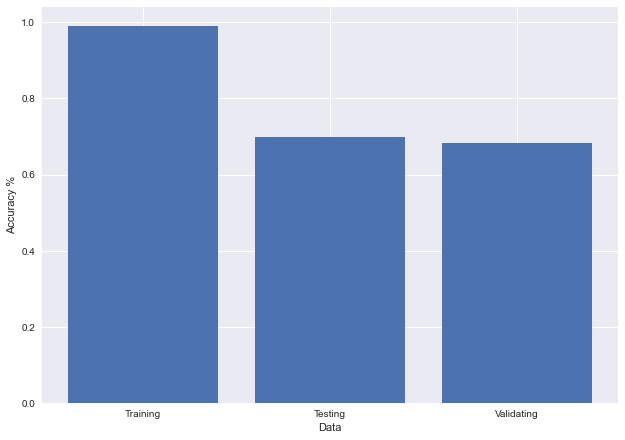

In [94]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
scores = [train_score,test_score,valid_score]
dataset = ['Training', 'Testing', 'Validating'] 
ax.bar(dataset, scores)
plt.xlabel('Data')
plt.ylabel('Accuracy %')
plt.show()

### Hyperparamter Tuning
The above model performance was done without any hyperparamter tuning. As a next step, we will perform hyperparameter tuning and observe if there's any improvement in the accuracy scores. To implement this, we will play aorund with the following parameters that are used in the Random Forest Classifier algorithm. [2](https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6)

i) random_state

ii) n_estimators

iii) min_samples_split

iv) min_sample_leaf

v) max_depth

We will be using only random_state, max_depth to perform hyperparameter tuning

In [51]:
#Adding parameters in the classifier algorithm
rf_hyptun = RandomForestClassifier(random_state = 2, max_depth =10000)
train_model = rf_hyptun.fit(train_important[:], Y_train)
pred_hyptun = train_model.predict(test_important[:])

#Evaluating training, testing and validation scores
train_score_hyptun = rf_hyptun.score(train_important[:], Y_train)
test_score_hyptun = rf_hyptun.score(test_important[:], Y_test)
valid_score_hyptun = rf_hyptun.score(valid_important[:], Y_valid)

#Printing the accuracy scores of training, testing and validation data
print ('Training data :', train_score_hyptun)
print('Testing data :', test_score_hyptun)
print('Validating data :', valid_score_hyptun)

#Evaluation metrics
errors = abs(pred_hyptun - Y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mae = round(np.mean(errors), 2)

mape = 100 * (errors / Y_test)

accuracy = 100 - np.mean(mape[np.isfinite(mape)])

print('Accuracy:', round(accuracy, 2), '%.')

Training data : 0.9914651493598862
Testing data : 0.6995260663507109
Validating data : 0.6829383886255924
Mean Absolute Error: 0.3 degrees.
Accuracy: 40.77 %.


/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3224943425.py:22: RuntimeWarning: divide by zero encountered in true_divide
  mape = 100 * (errors / Y_test)
/var/folders/vq/4wtg6xvn62n46nswq3p1yg280000gn/T/ipykernel_7221/3224943425.py:22: RuntimeWarning: invalid value encountered in true_divide
  mape = 100 * (errors / Y_test)


### Avoiding Overfitting
To avoid overfitting of data, we have ensured that the model gets trained on bigger training data size. Since we split our model into training , testing and validation data in the ratio of 40:30:30. this ensures the model gets trained on a larger data size than the ratio of data it has to predict. This will decrease the generalisation of any kind in the data that might lead to overfitting. 

Another method we ensured to avoiud overfitting is by simplifying the dataset by removing any kind of null and 'Nan' value that may cause error rate or mean computation to deflect.

### Learning curve
Below is the implementation of the learning curve of Random Forest classifier. For this purpose, we will split our data into 5 training data sizes ranging from 1 to 1000. We will plot the learning curve graph of the data with increasing training data size and visualise the mean squared error for training validation data.[3](https://www.dataquest.io/blog/learning-curves-machine-learning/)

We are using learning_curve method of sklearn model to plot the learning curve. The method uses the following parameters - 

i) estimator — indicates the learning algorithm we use to estimate the true model

ii) X — the data containing the features 

iii) y — the data containing the target 

iv) train_sizes — specifies the training set sizes to be used 

v) cv — determines the cross-validation splitting strategy 
 
vi) scoring — the intention is to use the mean squared error (MSE) metric

In [90]:
from sklearn.model_selection import learning_curve
features = ['Contract_Month-to-month', 'Contract_Two year', 'TotalCharges']
target = 'Churn'
train_sizes = [1, 100, 300, 500, 1000]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = RandomForestClassifier(),
X = df[features],
y = df[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

(0.0, 0.4)

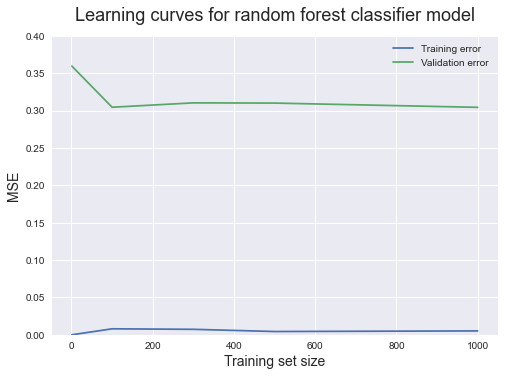

In [91]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for random forest classifier model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,0.4)

From the above learning curve, we can observe that the training error is almost 0 for training size of 1 and shows a mild increase for training size of 100, but stabalises after that point and remains constant for rest of the training sizes. Overall, the mean sqaure error is very minimal for all the training size.

Whereas, the validation error decreses with increasing training data size. Therefore, as we increase the training data size the model's error rate reduces and we can conclude that the model prediction also increases with larger data size.


### Model's performance
After playing around with the parameters, we observe no change in the overall accuracy. Therefore, we can assume the model's best performance is with pre-defined paramters. The accuracy score comes out to be 40.77%.

### _Question - 3_
Implementing supervised classification using a simple Feedforward Neural Network [1](https://www.kaggle.com/code/timniven/feedforward-neural-network-tutorial/notebook)

Importing pre-processed data

In [ ]:
import math
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [5]:
data = pd.read_csv('/content/drive/My Drive/Preprocessed_with_tenure.csv')
data
df= data
df

,Unnamed: 0,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,MonthlyCharges,TotalCharges,Date,tenure(months),Churn
0,0,1,0,1,0,0,1,0,1,0,...,1,0,0,1,0,65.60,593.30,2010-01-01,150,0
1,1,0,1,1,0,1,0,1,0,0,...,1,0,0,0,1,59.90,542.40,2010-01-01,150,0
2,2,0,1,1,0,1,0,1,0,0,...,1,0,1,0,0,73.90,280.85,2010-01-01,150,1
3,3,0,1,0,1,0,1,1,0,0,...,1,0,1,0,0,98.00,1237.85,2010-01-02,150,1
4,4,1,0,0,1,0,1,1,0,0,...,1,0,0,1,0,83.90,267.40,2010-01-03,150,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7027,1,0,1,0,1,0,1,0,1,...,0,1,0,0,0,55.15,742.90,2020-12-28,18,0
7028,7028,0,1,1,0,0,1,1,0,1,...,0,0,1,0,0,85.10,1873.70,2020-12-29,18,1
7029,7029,0,1,1,0,1,0,1,0,1,...,0,0,1,0,0,50.30,92.75,2020-12-29,18,0
7030,7030,0,1,1,0,0,1,0,1,1,...,0,0,1,0,0,67.85,4627.65,2020-12-30,18,0


From the previous model, we selected our top features from Feature selection method. They were - 'Contract_Month-to-month', 'TotalCharges', 'Contract_Two year'

We will set our top features, and target variable.

In [6]:
X=df[['Contract_Month-to-month', 'TotalCharges','Contract_Two year']]
y=df['Churn'].values

In [7]:
n_test = int(math.ceil(len(data) * 0.3))
random.seed(42)
test_ixs = random.sample(list(range(len(data))), n_test)
train_ixs = [ix for ix in range(len(data)) if ix not in test_ixs]
train = df.iloc[train_ixs, :]
test = df.iloc[test_ixs, :]

### Preparing data - 
This step is used to prepare data by selecting only important features and setting our target variable. 

We also normalise our data, this is done to ensure our neural network learns trivial things that can be used for model predictions. 

In [8]:
from sklearn import model_selection, preprocessing

features = ['Contract_Month-to-month', 'TotalCharges','Contract_Two year']
response = 'Churn'
x_train = train[features]
x_train = x_train.fillna(0)
y_train = train[response]
x_test = test[features]
x_test = x_test.fillna(0)
y_test = test[response]

#Normalising data
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

### Schematic diagram of feedforward  neural network
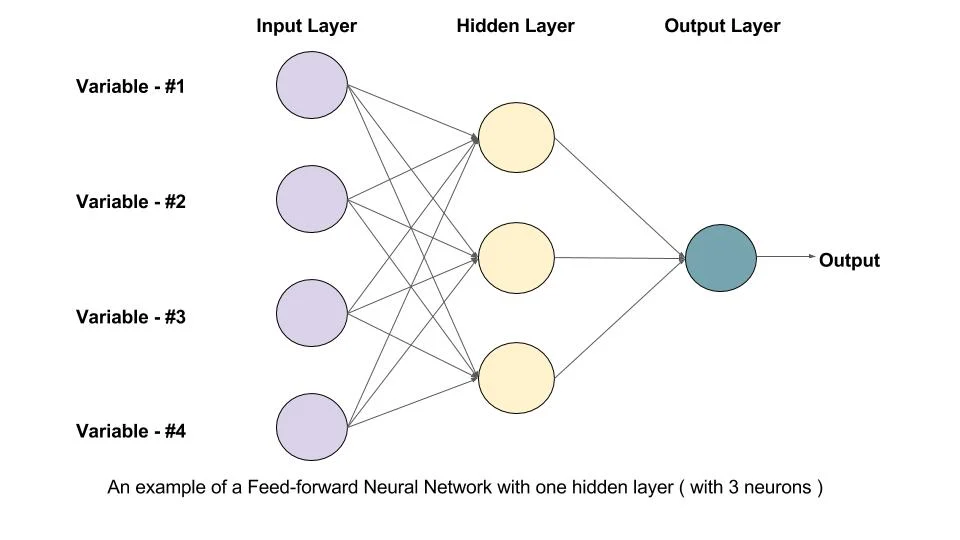

We have used 'keras' library to build simple package of feedforward neural network. 

We are going ahead with the below paramaters this will package our neural network. To keep our model simple, we are going ahead with only single hidden layer. 

The final layer is followed by a single output layer to perform classification.

We are using 'relu' as our activiation function.


In [9]:
hidden_units = 10     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 5            # how many epochs to train for
batch_size = 16       # how many samples to use for each gradient descent update

In [10]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=len(features),
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Learning Curve
After training our model, we evaluate its performance on our testing data and plot model's learning curve over loss function using 10 epochs.

We are plotting loss function for each step of epoch

Epoch 1/10
308/308 [==============================] - 1s 1ms/step - loss: 0.5935 - accuracy: 0.7099
Epoch 2/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5765 - accuracy: 0.7359
Epoch 3/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5763 - accuracy: 0.7359
Epoch 4/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5733 - accuracy: 0.7359
Epoch 5/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5699 - accuracy: 0.7359
Epoch 6/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5650 - accuracy: 0.7359
Epoch 7/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7359
Epoch 8/10
308/308 [==============================] - 0s 1ms/step - loss: 0.5534 - accuracy: 0.7359
Epoch 9/10
308/308 [==============================] - 1s 3ms/step - loss: 0.5480 - accuracy: 0.7359
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - loss: 0.5565 - accuracy: 0.7303
T

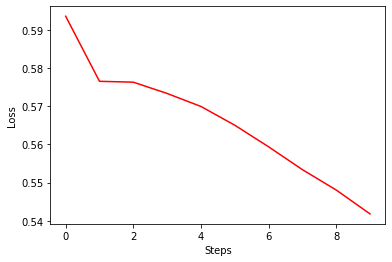

In [11]:
# train the parameters
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Train and evaluating model
We define the function to train and evaluate our model. To get best results, we train our model in 15 iterations and compute average of the training and testing scores.

In [12]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=15):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size,
                verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

### Evaluation metrics
We get a average training accuracy of 0.75 and testing accuracy of 0.72.

In [13]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████| 15/15 [00:41<00:00,  2.74s/it]

Avgerage Training Accuracy: 0.7405932585398356
Avgerage Testing Accuracy: 0.7245813687642415


To avoid overfitting of data, we simplify our model by reducing complexities with respect to input, hidden and output layers and limiting them to 1.
We also perform early stopping of our training process. By early-stopping, we ensure the data generalisation error doesn't occur.

Below is the plot for all the testing accuracy scores for each iterations

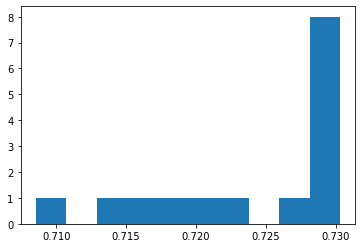

In [14]:
plt.hist(test_accs)
plt.show()

In [21]:
!pip install deepsig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 281 kB 73.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Statistical significance test 
To compare model's performance between Random forest classifier and feedforward neural network, we will perform statistical significance test.[4](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/)

We will calculate score from both these model and plot a box plot. 

In [1]:
import numpy as np
from deepsig import aso

seed = 1234
np.random.seed(seed)

# Simulate scores - neural netowrk 
N = 5  # Number of random seeds
my_model_scores = np.random.normal(loc=0.9, scale=0.8, size=N)
baseline_scores = np.random.normal(loc=0, scale=1, size=N)

min_eps = aso(my_model_scores, baseline_scores, seed=seed)
min_eps

Bootstrap iterations: 100%|█████████▉| 999/1000 [00:19<00:00, 52.42it/s] 


0.22488112073395775

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split



train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.30, random_state = 42)

train_important = train_features[['Contract_Month-to-month', 'TotalCharges','Contract_Two year']]
test_important = test_features[['Contract_Month-to-month', 'TotalCharges','Contract_Two year']]


rf = RandomForestClassifier()

# Simulate scores - Random forest classifier
rf_score = rf.fit(train_important.fillna(0), np.nan_to_num(train_labels)).score(test_important.fillna(0), np.nan_to_num(test_labels))
rf_score

0.6758293838862559

### Box-plot
Generating box plot from the scores. 

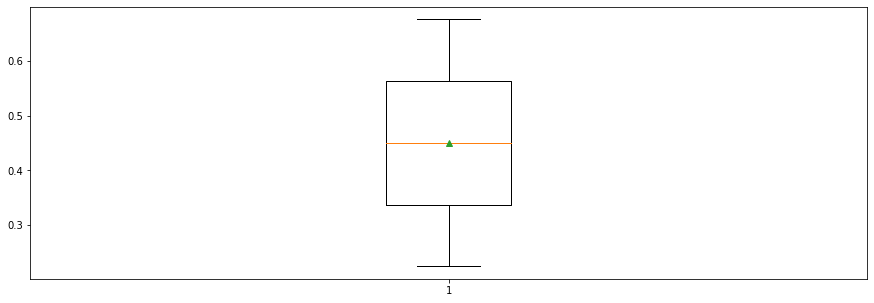

In [21]:
#Plotting the results using a box plot to compare the scores
# plot the results
from matplotlib import pyplot
plt.figure(figsize=(15,5))
pyplot.boxplot([min_eps, rf_score], showmeans=True)
pyplot.show()

### _Question 4: Concept Drift Detection_

In [191]:
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Date,tenure(months)
0,0002-ORFBO,Female,0,Yes,Yes,Yes,DSL,No,No,No,...,No,No,One year,Yes,Electronic Check,65.6,593.30,No,2010-01-01,150
1,0003-MKNFE,Male,0,No,No,Yes,No,No internet service,No internet service,No internet service,...,No internet service,No internet service,Month-to-month,Yes,Mailed Check,59.9,542.40,No,2010-01-01,150
2,0004-TLHLJ,Male,0,No,No,Yes,DSL,No,No,No,...,No,No,Month-to-month,Yes,Credit card (automatic),73.9,280.85,Yes,2010-01-01,150
3,0011-IGKFF,Male,1,Yes,No,Yes,DSL,No,No,No,...,No,No,Month-to-month,Yes,Credit card (automatic),98.0,1237.85,Yes,2010-01-02,150
4,0013-EXCHZ,Female,1,Yes,No,Yes,DSL,Yes,Yes,No,...,No,No,Month-to-month,Yes,Electronic Check,83.9,267.40,Yes,2010-01-03,150


In [199]:
# Selecting only the numerical features for concept drift detection.
df_numerical = churn_df.iloc[:, [16, 17, 20]]

In [200]:
df_numerical.head()

,MonthlyCharges,TotalCharges,tenure(months)
0,65.6,593.30,150
1,59.9,542.40,150
2,73.9,280.85,150
3,98.0,1237.85,150
4,83.9,267.40,150


Importing ADWIN (adaptive sliding window) for drift detection. [8](https://www.analyticsvidhya.com/blog/2021/10/mlops-and-the-importance-of-data-drift-detection/)

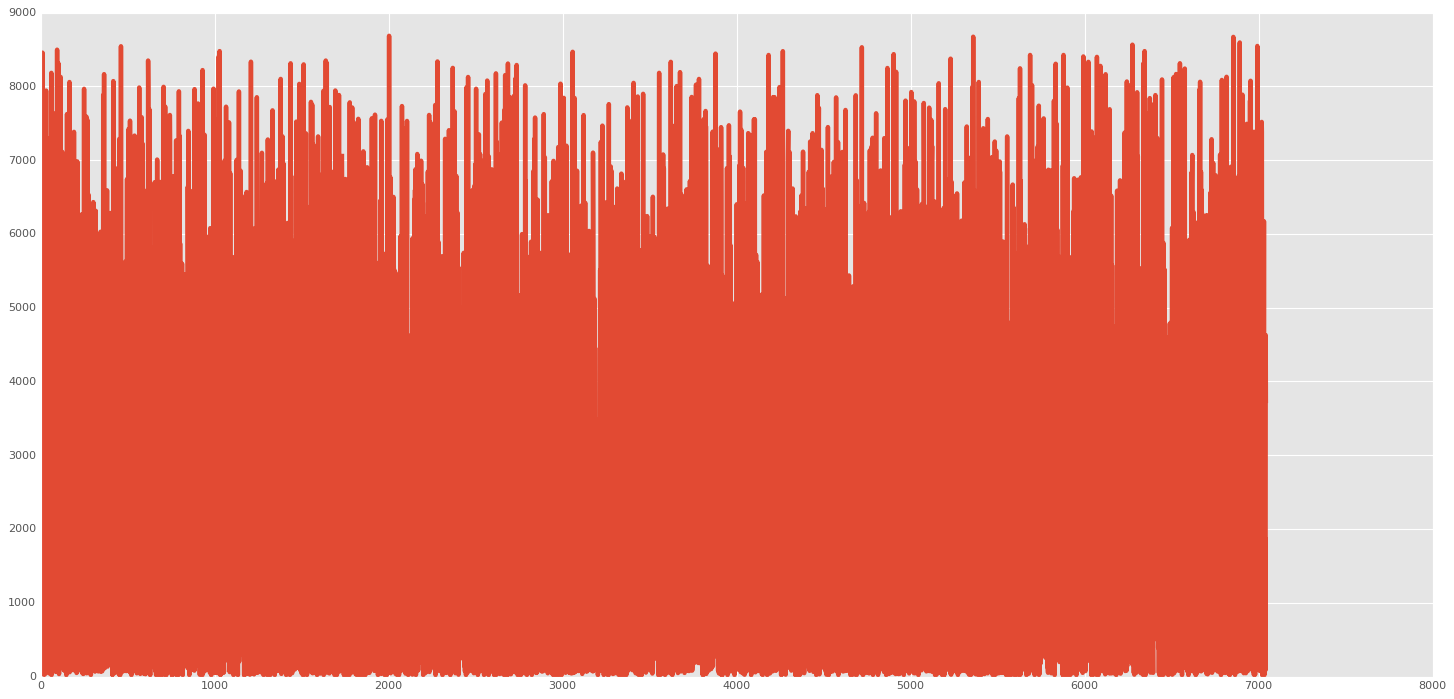

In [215]:
from skmultiflow.drift_detection import ADWIN
# instatiating ADWIN object
adwin = ADWIN() 
# checking for concept drift for 'TotalCharges' variable
df_totalcharges = df_numerical['TotalCharges'] 
df_totalcharges = np.array(df_totalcharges)
plt.figure(figsize=(20, 10))
plt.plot(df_totalcharges)

for i in range(len(df_totalcharges)):
    adwin.add_element(df_totalcharges[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(df_totalcharges[i]) + ' - at index: ' + str(i) +' for column:')  

The last 'IF' statement does not output anything. This implies there was no concept drift detected. Also, the figure above does not resemble any of the four types of concept drifts. The plot is quite uniform, suggesting that there is no concept drift at all. 

References


[1] https://www.kaggle.com/code/timniven/feedforward-neural-network-tutorial/notebook 

[2] https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

[3] https://www.dataquest.io/blog/learning-curves-machine-learning/

[4] https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/

[5] https://towardsdatascience.com/10-tricks-for-converting-numbers-and-strings-to-datetime-in-pandas-82a4645fc23d

[6] https://www.kaggle.com/code/mhslearner/telecom-churn-prediction/notebook

[7] https://stackoverflow.com/questions/42822768/pandas-number-of-months-between-two-dates#:~:text=df%5B'month'%5D%20%3D,%2C%20'M'

[8] https://www.analyticsvidhya.com/blog/2021/10/mlops-and-the-importance-of-data-drift-detection/

[9] https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43